In [3]:
#Let's import the necessary packages:
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import random
from transformers import GPT2Tokenizer
from transformers import AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer, AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.model_selection import train_test_split
import wandb
from rouge_score import rouge_scorer
import evaluate

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

In [1]:
pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00


In [2]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5d5be589ed17aff0c85112cf7eddbd31e54ad80db8172419b9019566bbb1cfe7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/My Drive/USD-AAI/cleaned_conversational_data_v1.csv")
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad again
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with pronunciation if that s okay with you
2,1,3,Not the hacking and gagging and spitting part. Please.,not the hacking and gagging and spitting part please
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,okay then how bout we try out some french cuisine saturday night
4,2,1,You're asking me out. That's so cute. What's your name again?,you re asking me out that s so cute what s your name again


In [6]:
df.shape

(304713, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Conversation ID  304713 non-null  int64 
 1   Turn ID          304713 non-null  int64 
 2   Text             304446 non-null  object
 3   cleaned_text     304276 non-null  object
dtypes: int64(2), object(2)
memory usage: 9.3+ MB


In [8]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()

83097

In [9]:
# Check for null values in the 'cleaned_text' column
null_values = df['cleaned_text'].isnull().sum()

print(f"Number of null values in 'cleaned_text': {null_values}")

Number of null values in 'cleaned_text': 437


In [10]:
df = df.dropna(subset=['cleaned_text'])

In [11]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()

83038

In [12]:
df.shape

(304276, 4)

In [13]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()

83038

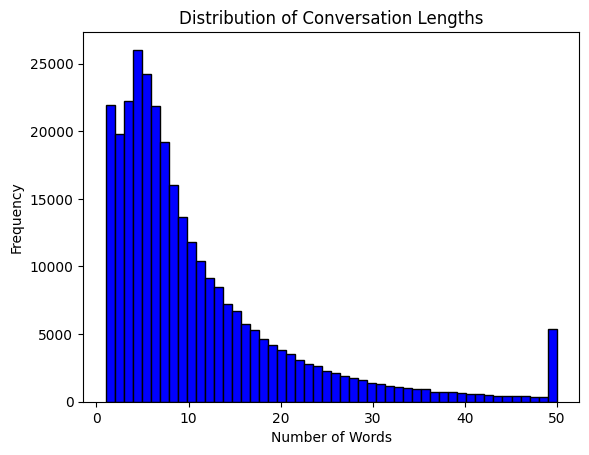

In [14]:
# Extract the cleaned text column for processing:
conversations = df['cleaned_text'].astype(str).tolist()

# Compute conversation lengths
conversation_lengths = [len(text.split()) for text in conversations]

# Plot the histogram of conversation lengths:
plt.hist(conversation_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Remove conversations that are too long or too short
upper_limit = np.percentile(conversation_lengths, 90)
lower_limit = 5  # Remove conversations shorter than 2 words

# Add conversation lengths to the DataFrame
df['conversation_lengths'] = conversation_lengths

# Filter the DataFrame
df = df[(df['conversation_lengths'] >= lower_limit) & (df['conversation_lengths'] <= upper_limit)]

In [16]:
df.shape

(184573, 5)

In [17]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()

75241

In [18]:
# Tokenize the conversations to get word counts
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# GPT2Tokenizer doesn't have fit_on_texts, use the tokenizer directly to count words
word_counts = {}
for text in df['cleaned_text']:
    for word in tokenizer.tokenize(text):
        word_counts[word] = word_counts.get(word, 0) + 1

# Identify words that occur at least 5 times
threshold = 5
words_to_keep = {word for word, count in word_counts.items() if count >= threshold}

# Function to remove rare words from text
def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word in words_to_keep])

# Apply the function to remove rare words from 'cleaned_text'
df['cleaned_text'] = df['cleaned_text'].apply(remove_rare_words)

# Drop rows where 'cleaned_text' is empty after removing rare words
df = df[df['cleaned_text'].str.strip().astype(bool)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()

75224

In [20]:
df.shape

(184503, 5)

In [21]:
# Load the GPT-2 tokenizer:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# GPT-2 doesn't have a pad token, so we'll set the end of sequence (EOS) token as the padding token:
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the `cleaned_text` column:
df['input_ids'] = df['cleaned_text'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=180, padding='max_length')
)

# Inspect the first few rows after tokenization:
df[['cleaned_text', 'input_ids']].head()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,cleaned_text,input_ids
0,can we make this quick and Andrew are having an break up on the again,"[5171, 356, 787, 428, 2068, 290, 6858, 389, 1719, 281, 2270, 510, 319, 262, 757, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
1,well i thought we d start with if that s with you,"[4053, 1312, 1807, 356, 288, 923, 351, 611, 326, 264, 351, 345, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
2,not the and and part please,"[1662, 262, 290, 290, 636, 3387, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
3,then how we try out some night,"[8524, 703, 356, 1949, 503, 617, 1755, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
4,you re me out that s so what s your name again,"[5832, 302, 502, 503, 326, 264, 523, 644, 264, 534, 1438, 757, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"


In [22]:
# Split the data into train (80%), validation (10%), and test (10%):
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check the sizes of the splits:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 147602
Validation set size: 18450
Test set size: 18451


In [23]:
# Create input-output pairs based on conversation turns:
def create_input_output_pairs(df):
    conversation_pairs = []
    grouped_conversations = df.groupby('Conversation ID')

    for _, group in grouped_conversations:
        group = group.sort_values(by='Turn ID')
        for i in range(len(group) - 1):
            input_text = group.iloc[i]['input_ids']
            response_text = group.iloc[i + 1]['input_ids']
            conversation_pairs.append((input_text, response_text))

    return conversation_pairs

# Generate input-output pairs for train, validation, and test datasets:
train_pairs = create_input_output_pairs(train_df)
val_pairs = create_input_output_pairs(val_df)
test_pairs = create_input_output_pairs(test_df)

# Check the number of pairs generated:
print(f"Total train pairs: {len(train_pairs)}")
print(f"Total validation pairs: {len(val_pairs)}")
print(f"Total test pairs: {len(test_pairs)}")

Total train pairs: 78286
Total validation pairs: 2262
Total test pairs: 2322


In [24]:
import torch
from torch.utils.data import Dataset

class ConversationDataset(Dataset):
    def __init__(self, tokenized_pairs):
        self.data = tokenized_pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, response_ids = self.data[idx]  # Each entry in data is (input_ids, response_ids)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(response_ids, dtype=torch.long)
        }

In [25]:
# Instantiate datasets:
train_dataset = ConversationDataset(train_pairs)
val_dataset = ConversationDataset(val_pairs)

# Create DataLoaders:
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Total train batches: {len(train_dataloader)}")
print(f"Total validation batches: {len(val_dataloader)}")

Total train batches: 4893
Total validation batches: 142


In [26]:
# Load the GPT-2 model:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Apply LoRA:
#peft_model = peft.get_peft_model(model, peft.LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1))

# Initialize the optimizer (AdamW):
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [27]:
# Initialize WandB:
wandb.init(project="gpt2-chatbot", name="finetuning")

# Watch the model to log gradients and weights:
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[]

In [28]:
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt2-chatbot",  # Unique run name for WandB
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=34, #16
    per_device_eval_batch_size=32, #16
    num_train_epochs=3,
    report_to="wandb",  # Reports metrics to WandB
    save_steps=1000,
    save_total_limit=3
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Train dataset
    eval_dataset=val_dataset,  # Validation dataset
    optimizers=(optimizer, None)  # Custom optimizer (AdamW)
)

# Start training
trainer.train()

Step,Training Loss,Validation Loss
500,0.278200,0.276817
1000,0.283900,0.275981
1500,0.265900,0.275546
2000,0.270100,0.275846
2500,0.278300,0.275242
3000,0.257600,0.277784
3500,0.283000,0.274977
4000,0.280300,0.275160
4500,0.276300,0.274797
5000,0.279100,0.274789


TrainOutput(global_step=6909, training_loss=0.27745346437057516, metrics={'train_runtime': 2424.491, 'train_samples_per_second': 96.869, 'train_steps_per_second': 2.85, 'total_flos': 2.157416861184e+16, 'train_loss': 0.27745346437057516, 'epoch': 3.0})

In [30]:
# Save the model using Hugging Face's save_pretrained method
model.save_pretrained('/content/drive/My Drive/USD-AAI/gpt2_model_v1')

In [31]:
tokenizer.save_pretrained('/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1')

('/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1/tokenizer_config.json',
 '/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1/special_tokens_map.json',
 '/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1/vocab.json',
 '/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1/merges.txt',
 '/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1/added_tokens.json')

In [32]:
from transformers import GPT2LMHeadModel, AutoTokenizer


# Load the base GPT-2 model from the directory where it was saved
model = GPT2LMHeadModel.from_pretrained('/content/drive/My Drive/USD-AAI/gpt2_model_v1', trust_remote_code=True)

# Load the tokenizer (assuming you saved the tokenizer as well in a separate directory)
tokenizer = AutoTokenizer.from_pretrained('/content/drive/My Drive/USD-AAI/gpt2_tokenizer_v1')

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [41]:
from transformers import GPT2LMHeadModel, AutoTokenizer, pipeline

# Create a text generation pipeline using the GPT-2 model and tokenizer
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)  # Use GPU if available

# Function to generate responses with truncation, temperature, and top-k sampling
def generate_response(prompt, max_length=100, temperature=0.7, top_k=50, max_new_tokens=50):
    """Generates a response with improved handling of truncation and diversity."""

    # Ensure the prompt and max_new_tokens together don't exceed the model's context window
    max_prompt_length = max_length - max_new_tokens
    truncated_prompt = tokenizer.decode(tokenizer.encode(prompt, truncation=True, max_length=max_prompt_length))

    response = generator(truncated_prompt,
                          max_length=max_length,
                          max_new_tokens=max_new_tokens,  # Limit the length of the generated response
                          temperature=temperature,  # Control randomness (lower value for less randomness)
                          top_k=top_k,  # Top-k sampling to improve diversity
                          num_return_sequences=1,
                          pad_token_id=tokenizer.eos_token_id)
    return response[0]['generated_text']

def chat_with_model():
    """Interactively chat with the model."""
    print("Start chatting with the model! (Type 'quit' to exit)\n")

    while True:
        # Get user input
        prompt = input("You: ")
        if prompt.lower() == 'quit':
            print("Exiting the chat. Goodbye!")
            break

        # Generate a response from the model
        # Call the generate_response function instead of the undefined 'generate' variable
        response = generate_response(prompt)
        print(f"Model: {response}")

In [42]:
chat_with_model()

Start chatting with the model! (Type 'quit' to exit)

You: hi


Both `max_new_tokens` (=50) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model: hi do n it
You: how are you


Both `max_new_tokens` (=50) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model: how are you to have
You: name?


Both `max_new_tokens` (=50) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model: name? n you the
You: not really


Both `max_new_tokens` (=50) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model: not really a
You: quit
Exiting the chat. Goodbye!
